## LikelihoodProfiler local optimizers comparison

Here we compare the efficiency of local derivative-free optimization algorithms applied to *Identifiability Analysis* with *LikelihoodProfiler* package. The following algorithms from *NLopt* library are compared on the basis of 
1. Number of loss function evaluation
2. How precise confidence inteval boundaries are estimated

In [1]:
using NLopt, Plots, LaTeXStrings, DataFrames, LikelihoodProfiler
# Algorithms list
algs = [
    :LN_NELDERMEAD,
    :LN_SBPLX,
    :LN_COBYLA,
    :LN_BOBYQA,
    :LN_PRAXIS
]

[ Info: Precompiling LikelihoodProfiler [93acb638-a083-5915-8dce-d129bc6a3f59]


5-element Vector{Symbol}:
 :LN_NELDERMEAD
 :LN_SBPLX
 :LN_COBYLA
 :LN_BOBYQA
 :LN_PRAXIS

The following loss function will be used for Parameters Identification:
$\Lambda(\theta) = 5 + (\theta_1-3)^2 + (exp(\theta_2)-1)^2 + 0*\theta_3$. We choose identification confidence level 𝛼=𝑙𝑜𝑠𝑠+3.84, where 𝑙𝑜𝑠𝑠 is the minimum loss function value obtained during fitting and 3.84 is Chi-square statistics with 1 degree of freedom and P-value=0.05.

In [2]:
# likelihood function
Λ(θ) = 5.0 + (θ[1]-3.0)^2 + (exp(θ[2])-1.0)^2 + 0.0*θ[3]
α = 5.0 + 3.84;

Let's plot the profiles for $\Lambda(\theta_1), \Lambda(\theta_2), \Lambda(\theta_3)$

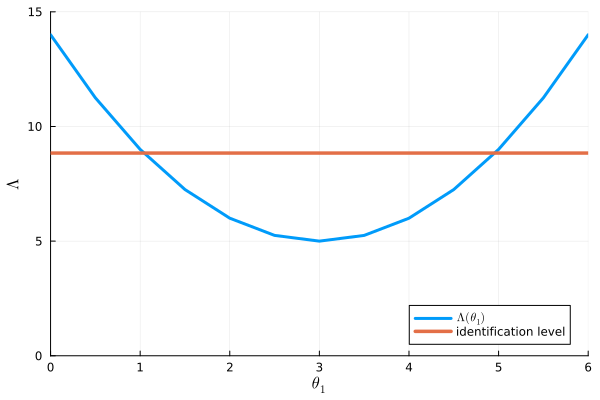

In [3]:

t = collect(0.0:0.5:10.0)
p1 = plot(t,[Λ([t_i,0.0,0.0]) for t_i in t],
          xlabel="\$\\theta_1\$",
          ylabel="\$\\Lambda\$",
          label="\$\\Lambda(\\theta_1)\$",
          xlims=(0.0,6.0),
          ylims=(0.0,15.),
          linewidth = 3.0);
plot!(x->α, linewidth = 3.5, label="identification level")
p2 = plot(t,[Λ([3.0,t_i,0.0]) for t_i in t],
          xlabel="\$\\theta_2\$",
          ylabel="\$\\Lambda\$",
          label="\$\\Lambda(\\theta_2)\$",
          xlims=(0.0,2.0),
          ylims=(0.0,20.),
          linewidth = 3.0);
plot!(x->α, linewidth = 3.5, label="identification level")
p3 = plot(t,[Λ([3.0,0.0,t_i]) for t_i in t], 
          xlabel="\$\\theta_3\$",
          ylabel="\$\\Lambda\$",
          label="\$\\Lambda(\\theta_3)\$",
          ylims=(0.0,15.),
          linewidth = 3.0);
plot!(x->α, linewidth = 3.5, label="identification level");

plot(p1)

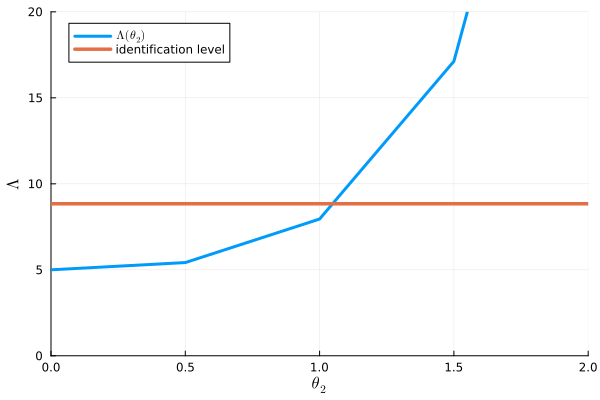

In [4]:
plot(p2)

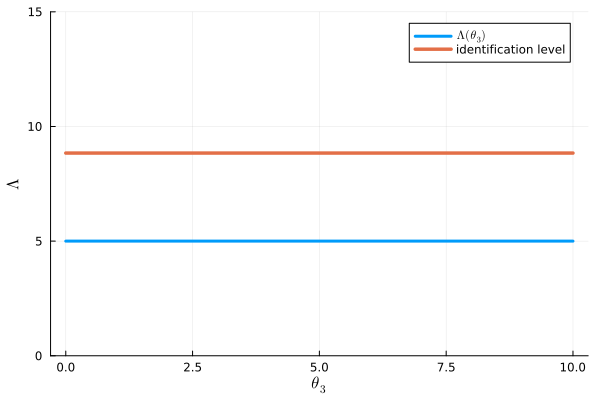

In [5]:
plot(p3)

Exact values for confidence intervals boundaries can be computed anlytically

In [6]:
# confidence intervals
exact_ci = DataFrame(
    params = [:θ₁, :θ₂, :θ₃],
    ci_lower = [-sqrt(3.84)+3.0, nothing, nothing],
    ci_upper = [sqrt(3.84)+3.0, log(sqrt(3.84)+1.0), nothing]
);
show(exact_ci)

3×3 DataFrame
 Row │ params  ci_lower  ci_upper 
     │ Symbol  Union…    Union…   
─────┼────────────────────────────
   1 │ θ₁      1.04041   4.95959
   2 │ θ₂                1.08505
   3 │ θ₃                         

Now we compute the same confidence intervals with *LikelihoodProfiler* package and the list of derivative-free optimization algorithms.

In [7]:
df = Dict{Symbol,DataFrame}()

for alg in algs
    res = [get_interval(
        [3., 0.1, 0.1], # :LN_NELDERMEAD is not stable when starting from values close to zero
        i,
        Λ,
        :CICO_ONE_PASS;
        loss_crit=α,
        local_alg=alg,
    ) for i in 1:3]
    
    df[alg] = DataFrame(
        params = params = [:θ₁, :θ₂, :θ₃],
        ci_lower_status = [p.result[1].status for p in res],
        ci_lower_count = [p.result[1].counter for p in res],
        ci_lower_value = [p.result[1].value for p in res],
        ci_upper_status = [p.result[2].status for p in res],
        ci_upper_count = [p.result[2].counter for p in res],
        ci_upper_value = [p.result[2].value for p in res]
    )
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\evgen\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
left CP counter: 292    Time: 0:00:00 ( 2.01 ms/it)


Results for *LN_NELDERMEAD, LN_SBPLX, LN_COBYLA, LN_BOBYQA, LN_PRAXIS*

In [8]:
show(df[:LN_NELDERMEAD],allcols=true)

3×7 DataFrame
 Row │ params  ci_lower_status           ci_lower_count  ci_lower_value  ci_upper_status           ci_upper_count  ci_upper_value 
     │ Symbol  Symbol                    Int64           Union…          Symbol                    Int64           Union…         
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ θ₁      BORDER_FOUND_BY_SCAN_TOL             292  1.04059         BORDER_FOUND_BY_SCAN_TOL             204  4.95941
   2 │ θ₂      SCAN_BOUND_REACHED                    37                  BORDER_FOUND_BY_SCAN_TOL             257  1.08468
   3 │ θ₃      SCAN_BOUND_REACHED                    37                  SCAN_BOUND_REACHED                    52                 

In [9]:
show(df[:LN_SBPLX],allcols=true)

3×7 DataFrame
 Row │ params  ci_lower_status           ci_lower_count  ci_lower_value  ci_upper_status           ci_upper_count  ci_upper_value 
     │ Symbol  Symbol                    Int64           Union…          Symbol                    Int64           Union…         
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ θ₁      BORDER_FOUND_BY_SCAN_TOL             345  1.04049         BORDER_FOUND_BY_SCAN_TOL             499  4.95964
   2 │ θ₂      SCAN_BOUND_REACHED                    46                  BORDER_FOUND_BY_SCAN_TOL             426  1.08504
   3 │ θ₃      SCAN_BOUND_REACHED                    18                  SCAN_BOUND_REACHED                    18                 

In [10]:
show(df[:LN_COBYLA],allcols=true)

3×7 DataFrame
 Row │ params  ci_lower_status           ci_lower_count  ci_lower_value  ci_upper_status           ci_upper_count  ci_upper_value 
     │ Symbol  Symbol                    Int64           Union…          Symbol                    Int64           Union…         
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ θ₁      BORDER_FOUND_BY_SCAN_TOL             419  1.0412          BORDER_FOUND_BY_SCAN_TOL             171  4.95662
   2 │ θ₂      SCAN_BOUND_REACHED                   371                  BORDER_FOUND_BY_SCAN_TOL             257  1.08507
   3 │ θ₃      SCAN_BOUND_REACHED                   371                  SCAN_BOUND_REACHED                   184                 

In [11]:
show(df[:LN_BOBYQA],allcols=true)

3×7 DataFrame
 Row │ params  ci_lower_status           ci_lower_count  ci_lower_value  ci_upper_status           ci_upper_count  ci_upper_value 
     │ Symbol  Symbol                    Int64           Union…          Symbol                    Int64           Union…         
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ θ₁      BORDER_FOUND_BY_SCAN_TOL              13  2.94939         BORDER_FOUND_BY_SCAN_TOL              13  3.05061
   2 │ θ₂      SCAN_BOUND_REACHED                    15                  BORDER_FOUND_BY_SCAN_TOL              23  0.930661
   3 │ θ₃      SCAN_BOUND_REACHED                    15                  SCAN_BOUND_REACHED                    15                 

In [12]:
show(df[:LN_PRAXIS],allcols=true)

3×7 DataFrame
 Row │ params  ci_lower_status           ci_lower_count  ci_lower_value  ci_upper_status           ci_upper_count  ci_upper_value 
     │ Symbol  Symbol                    Int64           Union…          Symbol                    Int64           Union…         
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ θ₁      BORDER_FOUND_BY_SCAN_TOL             320  1.04041         BORDER_FOUND_BY_SCAN_TOL             653  4.95962
   2 │ θ₂      SCAN_BOUND_REACHED                   193                  BORDER_FOUND_BY_SCAN_TOL             201  1.08505
   3 │ θ₃      SCAN_BOUND_REACHED                   167                  SCAN_BOUND_REACHED                   266                 